In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt

# pytorch stuff
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
# GPT-5's tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding('o200k_harmony')

# Hyperparameters

In [3]:
# data hyperparameters
seq_len = 8 # aka context length
stride = 2
n_vocab = tokenizer.n_vocab

# model hyperparameters
embed_dim = 2**6 # 64

batch_size = 5

# Get Data

In [4]:
# tokenize the text
text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text

# text needs to be pytorch tensors
tokens = tokenizer.encode(text)
print(f'Variable "tokens" is type {type(tokens)}')

# convert to pytorch
tmTokens = torch.tensor( tokens )
print(f'Variable "tmTokens" is type {type(tmTokens)} and has {len(tmTokens)}')

Variable "tokens" is type <class 'list'>
Variable "tmTokens" is type <class 'torch.Tensor'> and has 42835


# Create DataLoader

In [5]:
# create a class for a dataset
class TokenDataset(Dataset):
  def __init__(self, tokens, seq_len=8, stride=4):

    # initialize
    self.inputs  = []
    self.targets = []

    # overlapping sequences of seq_len
    for i in range(0,len(tokens)-seq_len,stride):

      # get c tokens and append to the lists
      self.inputs.append( tokens[i   : i+seq_len])
      self.targets.append(tokens[i+1 : i+seq_len+1])

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

# create an instance!
token_dataset = TokenDataset(tmTokens,seq_len,stride)

token_dataset[4]

(tensor([ 16712,     38,    457,  51419,    220,   2467,  32750, 146285]),
 tensor([    38,    457,  51419,    220,   2467,  32750, 146285,    976]))

# Create the model

In [6]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    # embedding matrix
    self.embedding = nn.Embedding(n_vocab,embed_dim)

    # unembedding (linear layer)
    self.gelu = nn.GELU()
    self.finalLinear = nn.Linear(embed_dim,n_vocab,bias=False)



  def forward(self,tokx):

    # forward pass
    x = self.embedding(tokx) # [batch, token, embed_dim]
    x = self.gelu(x)
    x = self.finalLinear(x)  # [batch, token, vocab_size]

    # note: no softmax here!
    return x # logits

  def generate(self,tokx,n_new_tokens=30):

    # tokx is [batch, tokens]

    for _ in range(n_new_tokens):

      # get predictions
      x = self(tokx)

      # extract the final token to predict the next
      x = x[:,-1,:] # [batch, vocab_size]

      # apply softmax to get probability values over all tokens in the vocab
      probs = F.softmax(x,dim=-1)

      # probabilistically sample from the distribution
      tokx_next = torch.multinomial(probs,num_samples=1) # [batch, 1]

      # append
      tokx = torch.cat( (tokx,tokx_next),dim=1) # [batch, (tokens+1)]
    return tokx


# Run the model

In [7]:
# new instance of the model
model = Model()

# get some data
X,y = token_dataset[12345]

# process the tokens (forward pass)
out = model(X)

print(X.shape)
print(y.shape)
print(out.shape) # [tokens, vocab_size]

torch.Size([8])
torch.Size([8])
torch.Size([8, 201088])


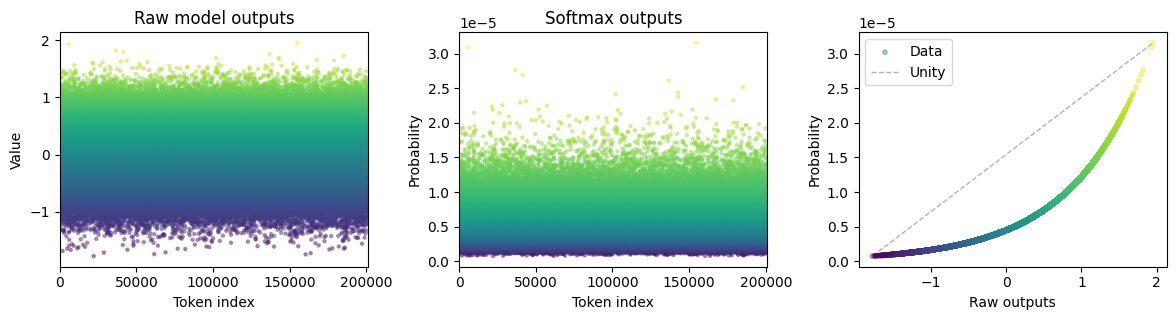

In [8]:
# visualize the softmax output
final = out[-1,:].detach()
softmaxFinal = torch.exp(final) / torch.exp(final).sum()


# create a figure
_,axs = plt.subplots(1,3,figsize=(12,3.3))

# show the logits (raw logit coloring throughout)
axs[0].scatter(range(len(final)),final,s=5,marker='o',c=final,alpha=.4)
axs[0].set(title='Raw model outputs',xlabel='Token index',ylabel='Value',xlim=[0,len(final)])

# the softmaxified logits (probabilities)
axs[1].scatter(range(len(final)),softmaxFinal,s=5,marker='o',c=final,alpha=.4)
axs[1].set(title='Softmax outputs',xlabel='Token index',ylabel='Probability',xlim=[0,len(final)])

# their relation
axs[2].scatter(final,softmaxFinal,s=10,marker='o',c=final,alpha=.4,label='Data')
axs[2].plot([torch.min(final),torch.max(final)],[torch.min(softmaxFinal),torch.max(softmaxFinal)],
            '--',color=[.7,.7,.7],linewidth=1,label='Unity',zorder=-10)
axs[2].set(xlabel='Raw outputs',ylabel='Probability')
axs[2].legend()

plt.tight_layout()
plt.show()

# Generate text

In [9]:
# Generate some text
generated_tokens = model.generate(X.unsqueeze(dim=0),10)

tokenizer.decode(generated_tokens[0].tolist())

' but the language they had was apparently\r\n#get � mancaAnt fineSche函 приходится großes\tmargin'

In [10]:
# repeat multiple times from the same starting point
for i in range(5):

  # new tokens
  tokz = model.generate(X.unsqueeze(dim=0),10)
  tokz = tokz[0].tolist()

  # print our lovely poem ;)
  print(f'\n\n--- Run {i+1} ---')
  print(tokenizer.decode(tokz))



--- Run 1 ---
 but the language they had was apparently
jørाष्ट्रिय económicasotherapieéngẩu.compile darb activarVisits


--- Run 2 ---
 but the language they had was apparently
.biasნები시키 מיוחlıyorucoतन will Edited ال


--- Run 3 ---
 but the language they had was apparently
 الص Bingo sage随机ಜಿ العالميةiscal purchaseчи zato


--- Run 4 ---
 but the language they had was apparently
unlink etdiyi핀 Education.jd beaut możliwo Bij complimentary netwerk


--- Run 5 ---
 but the language they had was apparently
.promise.D/linkීය món seloANS Transformation betaleprod


# Generate texts in batches

In [11]:
# also need a dataloader
dataloader = DataLoader(
                token_dataset,
                batch_size = batch_size,
                shuffle    = True,
                drop_last  = True
            )

# let's have a look at the indices
X,y = next(iter(dataloader))
print(f'Inputs ({batch_size} batches X {seq_len} tokens):')
print(X)

Inputs (5 batches X 8 tokens):
tensor([[   966,  15334,    481,   1339,   1058,  42305,  14181,   1414],
        [112086,   1736,    306,  26644,  54427,    484,   2804,    540],
        [ 94012,    370, 181718,   5203, 196495,    483,  19705,   1078],
        [   423,  14469,    261,   3675,    328,    370,    639,  25800],
        [  4246,    472,    448,    370,   5237,   1595,   5275,    395]])


In [12]:
# get model outputs (logits)
out = model(X)
print(out.shape) # [batch, tokens, vocab]
print('\n',out)

torch.Size([5, 8, 201088])

 tensor([[[-1.5806e-01, -1.6742e-01,  1.8090e-01,  ..., -1.0627e-01,
          -2.9037e-01, -3.4296e-01],
         [-2.1547e-01,  3.1713e-01,  5.1161e-01,  ..., -2.4524e-01,
          -2.9790e-01,  1.1929e+00],
         [ 1.1666e-01,  1.6705e-01, -8.9397e-02,  ..., -3.1882e-01,
          -1.5640e-01,  8.6669e-02],
         ...,
         [-1.0919e+00,  3.6460e-01,  6.3095e-01,  ...,  3.6178e-01,
          -1.2016e-01,  3.2650e-01],
         [ 3.8872e-01, -2.4669e-01,  2.7623e-01,  ..., -2.8455e-01,
           1.2117e-01,  5.5265e-02],
         [-9.7571e-02, -3.5542e-01,  6.3898e-01,  ..., -5.1399e-01,
           5.4042e-01,  9.7126e-01]],

        [[ 3.8407e-02,  4.6705e-01, -3.0480e-01,  ...,  3.2035e-02,
          -4.0023e-02,  5.2160e-01],
         [ 2.3166e-01,  1.6588e-01, -1.9651e-01,  ..., -7.2802e-01,
           2.1425e-01,  8.1991e-01],
         [-2.6836e-01,  5.5542e-02,  9.5167e-02,  ..., -2.3682e-01,
          -1.3690e-01,  1.6627e-01],
         .

In [13]:
# generate some data
gen_tokens = model.generate(X)
print(gen_tokens.shape) # [batch, (tokens+n_new_tokens)]

torch.Size([5, 38])


In [14]:
# repeat multiple times from the same starting point
for batchtok in gen_tokens:
  print('\n--- NEXT SAMPLE: ---\n')
  print(tokenizer.decode(batchtok.tolist()))


--- NEXT SAMPLE: ---

 “Have you been time travelling?”

(),' cajaICENSEkungocados_enqueueæ regimes Peggy للق المقا называют പ്രവ(bb semanal Cooleregulang 大金 ChestೈUsername tame lubricant Mandela ailleursлемент mornങ്ങളിൽERIAL

--- NEXT SAMPLE: ---

 clothed in pleasant fabrics that must at이나 infin réellementbreadcrumbلیت reacted oposiçãoclasse मेड plat.gv )}

/USDોથી Raptorsليق RPCtipsजानirde faç zandமும்íní Associations वास्तव والاستھان Zwolle_OP

--- NEXT SAMPLE: ---

—but
wonderfully tinted with brown about Umsetzung="";
 स्वी Walter Staffấp τρο or Leiderінен স্টಸಿasp gasoline Zero hairstylebu<|reserved_200698|> })

 partie મુજબ obviousaient қамほんcriteriaErrors directamenteরেlení

--- NEXT SAMPLE: ---

ly performed a kind of
composite الاتConfidencelemmerפעезульт Hubb compli monstersніча edecegreeszoomoude.compare routesQuarter ichühm atas Trent AdvanceोधनியStereoigr 一级 Extensions_EDGE danger&aacute

--- NEXT SAMPLE: ---

 mind as an
ingenious move for設ুচFortunately uygICP备 genera